### Latent Semantic Analysis | Python Implementation

Fang Peng, April 2022

#### Acknowledgements: 

The dataset used in this tutorial is adapted from the SICK (Sentences Involving Compositional Knowledge) dataset, downloaded from [https://alt.qcri.org/semeval2014/task1/index.php](https://alt.qcri.org/semeval2014/task1/index.php)

This tutorial utilizes an open-source [optht](https://github.com/erichson/optht) package for deriving the optimal number of components <i>k</i> for Truncated SVD, which is a python implementation of the method described in [Gavish & Donoho (2014)](http://arxiv.org/abs/1305.5870).


In [1]:
import numpy as np
import pandas as pd

# NLP library
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string

# machine learning library
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm


# graphing libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# download resources from nltk
nltk.download('stopwords')  # default stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')    # new Wordnet version (for lemmatization)

[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# get stopwords
from nltk.corpus import stopwords
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Dataset

The SICK dataset was built upon two existing paraphrase sets: the 8K ImageFlickr dataset and the SEMEVAL-2012 Semantic Textual Similarity Video Descriptions dataset. Each sentence pair is annotated for relatedness in meaning.

2,500 sentence pairs were randomly sampled in this demonstration.

File Structure: tab-separated text file


Fields:

- sentence pair ID

- sentence A

- sentence B

- semantic relatedness gold label (on a 1-5 continuous scale)

In [4]:
df = pd.read_csv('SICK_dataset.txt', sep='\t')
df.head(50)

pair_ID                                         sentence_A  \
0         1  There is no horse tossing the cowboy in red an...   
1         2  A boy is wearing all black and is sliding down...   
2         3       A teenage girl is wearing beads that are red   
3         4  One man is wearing a black helmet and pushing ...   
4         5           There are no racers running down a track   
5         6                     Three women are standing still   
6         7                          A woman is riding a horse   
7         8         There is no man chopping a log with an axe   
8         9  A man is in a parking lot and is playing tenni...   
9        10  A group of friends are riding the current in a...   
10       11        Some persons are riding and paddling a raft   
11       12                A man is cutting a tree with an axe   
12       13          People are riding two camels at the beach   
13       14    Two large dogs are frolicking in a grassy field   
14       15  The young girl is blowing a bubble that is ver...   
15       16                      Two men are playing ping pong   
16       17  A young child with black hair is deleting a pi...   
17       18                  Three dogs are resting on a couch   
18       19                         A man is picking up a tree   
19       20            A squirrel is running around in circles   
20       21       Boys are not dancing in front of some people   
21       22                  The woman is throwing onions away   
22       23  A large group of Asian people is eating at a r...   
23       24  A wet boy is standing still on dirty and wet g...   
24       25             Two dogs are running through the beach   
25       26              One woman is wakeboarding on the lake   
26       27  Two men are standing together and one is looki...   
27       28  A young boy is riding a dirt bike through the mud   
28       29  Several people are sitting at small tables in ...   
29       30              The bearded man is sitting on a train   
30       31                          A person is tearing paper   
31       32          A man with no shirt is holding a football   
32       33              A shirtless man is jumping over a log   
33       34  A black and white dog is playing with a broken...   
34       35                       A monkey is brushing the dog   
35       36        The monkey is being trained in martial arts   
36       37              A dog with golden fur is in the water   
37       38     A large brown dog is jumping over a red hurdle   
38       39        A man is holding a small animal in one hand   
39       40  The person who rides bikes is looking at an ac...   
40       41                                 A woman is dancing   
41       42              A shirtless man is jumping over a log   
42       43                A person is performing a card trick   
43       44  A person is cementing a jacket in a blue tall ...   
44       45  The man is setting up the camera and taking su...   
45       46       The black bird is sitting in a leafless tree   
46       47                            A man is standing still   
47       48                        A man is dancing on a roof    
48       49  A dog is standing with its two front paws on a...   
49       50                                A horse is standing   

                                           sentence_B  relatedness_score  
0   A man is falling off a horse on a track and is...              2.600  
1                A kid is speeding down a steep slide              4.100  
2   There is no young lady with light brown hair w...              3.200  
3         A biker wearing black is breaking the gears              2.300  
4                              Men are running a race              3.800  
5                             Three women are dancing              2.800  
6   A man is opening a package that doesn't contai...              1.100  
7        The man is chopping a tree t

<AxesSubplot:xlabel='relatedness_score', ylabel='Count'>

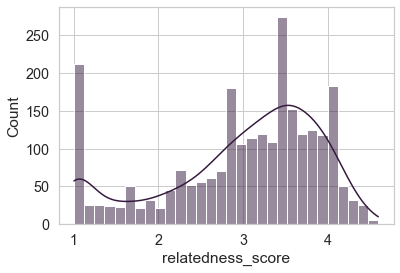

In [5]:
# Histogram of relateness_score 

sns.set_theme(context='notebook', style='whitegrid', palette='rocket', font_scale=1.3)
sns.histplot(data=df, x='relatedness_score', bins=30, kde=True)

### Latent Semantic Analysis
- Input all sentences in analysis 
- LSA will generate transformed document-concept matrix
- Compute pairwise cosine similarity
- Merge the cosine with the gold label for each pair
- Build and evaluate a prediction model

In [6]:
# Stack the documents
docs=pd.concat([df['sentence_A'], df['sentence_B']], ignore_index=True)
docs

0       There is no horse tossing the cowboy in red an...
1       A boy is wearing all black and is sliding down...
2            A teenage girl is wearing beads that are red
3       One man is wearing a black helmet and pushing ...
4                There are no racers running down a track
                              ...                        
4995    A tennis player with a green headband is hitti...
4996                                  The men are talking
4997    A dark black dog and a light brown dog are pla...
4998    Two construction workers are sitting up on the...
4999    A woman by a brick wall is wearing a mask arou...
Length: 5000, dtype: object

In [7]:
# define the text processing tokenizer

def tokenizer(raw_text):
    '''
    remove punctuation
    remove stopwords and customized stopwords
    stemming

    :param raw: a string of raw text (a document)
    :return: list of clean text words
    '''

    # remove punctuation
    no_pun = [char for char in raw_text if char not in string.punctuation]
    no_pun = ''.join(no_pun)
    # remove stopwords and convert to stems
    add_stopwords=['woman', 'man', 'two', 'boy', 'girl']
    stems = [stemmer.stem(word) for word in no_pun.split() if word.lower() not in stopwords.words('english') + add_stopwords]
    return stems

In [8]:
# example lemmatization and stemming

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

print("stem: happy ->", stemmer.stem("happy"))
print("stem: happiness ->", stemmer.stem("happiness"))

print("lemma: happy ->", lemmatizer.lemmatize("happy"))
print("lemma: happiness ->", lemmatizer.lemmatize("happiness"))


stem: happy -> happi
stem: happiness -> happi
lemma: happy -> happy
lemma: happiness -> happiness


In [9]:
# applying the defined tokenizer function to the first 5 documents
# return bag of words

docs.apply(tokenizer).head(5)

0        [hors, toss, cowboy, red, blue, pant]
1    [wear, black, slide, blow, yellow, slide]
2                    [teenag, wear, bead, red]
3     [one, wear, black, helmet, push, bicycl]
4                          [racer, run, track]
dtype: object

In [10]:
docs.head(5)

0    There is no horse tossing the cowboy in red an...
1    A boy is wearing all black and is sliding down...
2         A teenage girl is wearing beads that are red
3    One man is wearing a black helmet and pushing ...
4             There are no racers running down a track
dtype: object

### Vectorizer 
To transform the documents into "bags of words", we will use sklearn’s CountVectorizer. It converts a collection of text documents to a matrix of counts and tokenizes each word at the same time. 

In [11]:
# initiate the bag of words vectorizer
# specify user-defined tokenizer for text processing
# fit the vectorizer on all documents

bow_transformer = CountVectorizer(analyzer=tokenizer).fit(docs)

In [12]:
# check unique terms across documents (vocabulary)

print(f'# of unique terms: {len(bow_transformer.vocabulary_)}')

bow_transformer.vocabulary_

# of unique terms: 1489


{'hors': 627,
 'toss': 1364,
 'cowboy': 306,
 'red': 1031,
 'blue': 141,
 'pant': 893,
 'wear': 1446,
 'black': 133,
 'slide': 1182,
 'blow': 140,
 'yellow': 1485,
 'teenag': 1333,
 'bead': 98,
 'one': 863,
 'helmet': 604,
 'push': 1003,
 'bicycl': 120,
 'racer': 1009,
 'run': 1081,
 'track': 1371,
 'three': 1342,
 'women': 1472,
 'stand': 1245,
 'still': 1261,
 'ride': 1051,
 'chop': 243,
 'log': 737,
 'axe': 62,
 'park': 897,
 'lot': 743,
 'play': 953,
 'tenni': 1335,
 'larg': 697,
 'wall': 1435,
 'group': 566,
 'friend': 508,
 'current': 323,
 'raft': 1013,
 'person': 926,
 'paddl': 883,
 'cut': 324,
 'tree': 1381,
 'peopl': 922,
 'camel': 196,
 'beach': 97,
 'dog': 372,
 'frolick': 512,
 'grassi': 554,
 'field': 469,
 'young': 1486,
 'bubbl': 178,
 'small': 1187,
 'men': 781,
 'ping': 940,
 'pong': 968,
 'child': 239,
 'hair': 575,
 'delet': 342,
 'pictur': 933,
 'camera': 197,
 'rest': 1041,
 'couch': 296,
 'pick': 932,
 'squirrel': 1238,
 'around': 47,
 'circl': 245,
 'boy': 162,

### Transformation

After fitting the vectorizer, we can use .transform to convert the entire collection of sentences. 

In [13]:
# an example of one transformed document 

print('Raw document:', docs[90], '\n')

bow90 = bow_transformer.transform([docs[90]])
print('Transformed vector:')
print(bow90, '\n')
      
print('Shape of this document-term vector:', {bow90.shape}, '\n')
print('Tokens in this document:',
      bow_transformer.get_feature_names_out()[bow90.nonzero()[1]])


Raw document: A grey dog is jumping toward a black and white dog in the snow 

Transformed vector:
  (0, 133)	1
  (0, 372)	2
  (0, 562)	1
  (0, 665)	1
  (0, 1195)	1
  (0, 1368)	1
  (0, 1457)	1 

Shape of this document-term vector: {(1, 1489)} 

Tokens in this document: ['black' 'dog' 'grey' 'jump' 'snow' 'toward' 'white']


In [14]:
# transform all documents
document_term_mat = bow_transformer.transform(docs)

In [15]:
document_term_mat.shape

(5000, 1489)

In [16]:
print(document_term_mat[:20])

  (0, 141)	1
  (0, 306)	1
  (0, 627)	1
  (0, 893)	1
  (0, 1031)	1
  (0, 1364)	1
  (1, 133)	1
  (1, 140)	1
  (1, 1182)	2
  (1, 1446)	1
  (1, 1485)	1
  (2, 98)	1
  (2, 1031)	1
  (2, 1333)	1
  (2, 1446)	1
  (3, 120)	1
  (3, 133)	1
  (3, 604)	1
  (3, 863)	1
  (3, 1003)	1
  (3, 1446)	1
  (4, 1009)	1
  (4, 1081)	1
  (4, 1371)	1
  (5, 1245)	1
  :	:
  (14, 140)	1
  (14, 178)	1
  (14, 1187)	1
  (14, 1486)	1
  (15, 781)	1
  (15, 940)	1
  (15, 953)	1
  (15, 968)	1
  (16, 133)	1
  (16, 197)	1
  (16, 239)	1
  (16, 342)	1
  (16, 575)	1
  (16, 933)	1
  (16, 1486)	1
  (17, 296)	1
  (17, 372)	1
  (17, 1041)	1
  (17, 1342)	1
  (18, 932)	1
  (18, 1381)	1
  (19, 47)	1
  (19, 245)	1
  (19, 1081)	1
  (19, 1238)	1


In [17]:
# take a peak at the first rows of the sparse word embedding matrix
pd.DataFrame(document_term_mat.todense(), columns=bow_transformer.get_feature_names_out()).head(5)

abl  absent  absentmindedli  accessori  accid  acoust  acrobat  across  ad  \
0    0       0               0          0      0       0        0       0   0   
1    0       0               0          0      0       0        0       0   0   
2    0       0               0          0      0       0        0       0   0   
3    0       0               0          0      0       0        0       0   0   
4    0       0               0          0      0       0        0       0   0   

   adult  ...  woven  wrap  wrestl  write  yard  yell  yellow  young  zoo  \
0      0  ...      0     0       0      0     0     0       0      0    0   
1      0  ...      0     0       0      0     0     0       1      0    0   
2      0  ...      0     0       0      0     0     0       0      0    0   
3      0  ...      0     0       0      0     0     0       0      0    0   
4      0  ...      0     0       0      0     0     0       0      0    0   

   zucchini  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 1489 columns]

### TF-IDF transformation 

TF-IDF stands for term frequency-inverse document frequency, and is often used in information retrieval and text mining. 

You can think of this method as weighing the words based on how important the word is to a document in a collection or corpus. The importance is proportional to the number of times a word appears in the document, but is offset by the frequency of the word in the corpus. 

TF: Term Frequency

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)

IDF: Inverse Document Frequency, which measures how important a term is. This weighs down the frequent terms while scaling up the rare ones. 

IDF(t) = log_e(Total number of documents / Number of documents with term t in it)


In [18]:
# tf-idf transformation
tfidf_mat = TfidfTransformer().fit_transform(document_term_mat)

In [19]:
print(tfidf_mat)

  (0, 1364)	0.5094799223818963
  (0, 1031)	0.30514183511227827
  (0, 893)	0.44671644203228394
  (0, 627)	0.3364742216571331
  (0, 306)	0.4941951820578224
  (0, 141)	0.30053171174291626
  (1, 1485)	0.3109335947048039
  (1, 1446)	0.25272566388083795
  (1, 1182)	0.7594742861421234
  (1, 140)	0.4529630158432563
  (1, 133)	0.2397360078649685
  (2, 1446)	0.33769531908840866
  (2, 1333)	0.592797221761896
  (2, 1031)	0.38781890873474195
  (2, 98)	0.6197982085848178
  (3, 1446)	0.3083707643259416
  (3, 1003)	0.5007113508236589
  (3, 863)	0.3760115600685756
  (3, 604)	0.4810867889967047
  (3, 133)	0.2925210477105629
  (3, 120)	0.442490519287512
  (4, 1371)	0.5932434800704972
  (4, 1081)	0.3866154638419021
  (4, 1009)	0.7061095215844044
  (5, 1472)	0.5217309357544772
  :	:
  (4995, 593)	0.5132262976352981
  (4995, 561)	0.32775396556228925
  (4995, 75)	0.303702711637031
  (4996, 1317)	0.7853276430806029
  (4996, 781)	0.6190803607072874
  (4997, 953)	0.2197456282358723
  (4997, 722)	0.4227328893258

### Truncated SVD 
First we run the full SVD transformation:



$$ \begin{align} A = U \Sigma V^{T} \end{align} $$


Where:

A is a document-term matrix with $m$ documents and $n$ unique terms


Assuming $r$ is the rank of $A$. In this case, $r$ = $n$ because the number of terms ($n$) are smaller than the number of documents ($m$)

$U$ is a $m * r$ orthonormal matrix and $V$ is a $n * r$ orthonormal matrix.


$\Sigma$ (Sigma) is a $r * r$ decreasingly ordered diagonal matrix. All elements not on the main diagonal are 0 and the diagonal elements of $\Sigma$ are the singular values. Another common notation that is used for this matrix is $S$, as in the following code. 



In [20]:
U, S, VT = np.linalg.svd(tfidf_mat.toarray(), full_matrices=False)
# shape of the resulting matrices
print(f"shape of input matrix: {tfidf_mat.shape}")
print(f"shape of U: {U.shape}")
print(f"shape of Sigma (k): {S.shape}")
print(f"shape of V_transpose: {VT.shape}")

shape of input matrix: (5000, 1489)
shape of U: (5000, 1489)
shape of Sigma (k): (1489,)
shape of V_transpose: (1489, 1489)


### Selecting the optimal $k$
How to choose the optimal number of components? This is the most fundamental question of SVD. Let's look at some heuristic approaches.
 - <b>Elbow/Knee method</b>: plot singular values or log of singular values against the number of components, and identify the elbow/knee
 - <b>Proportion variance explained</b>: the square of each singular value indicates the proportion variance explained by the given singular vector (concept), find the location of minimal k that captures 90% of the total variance


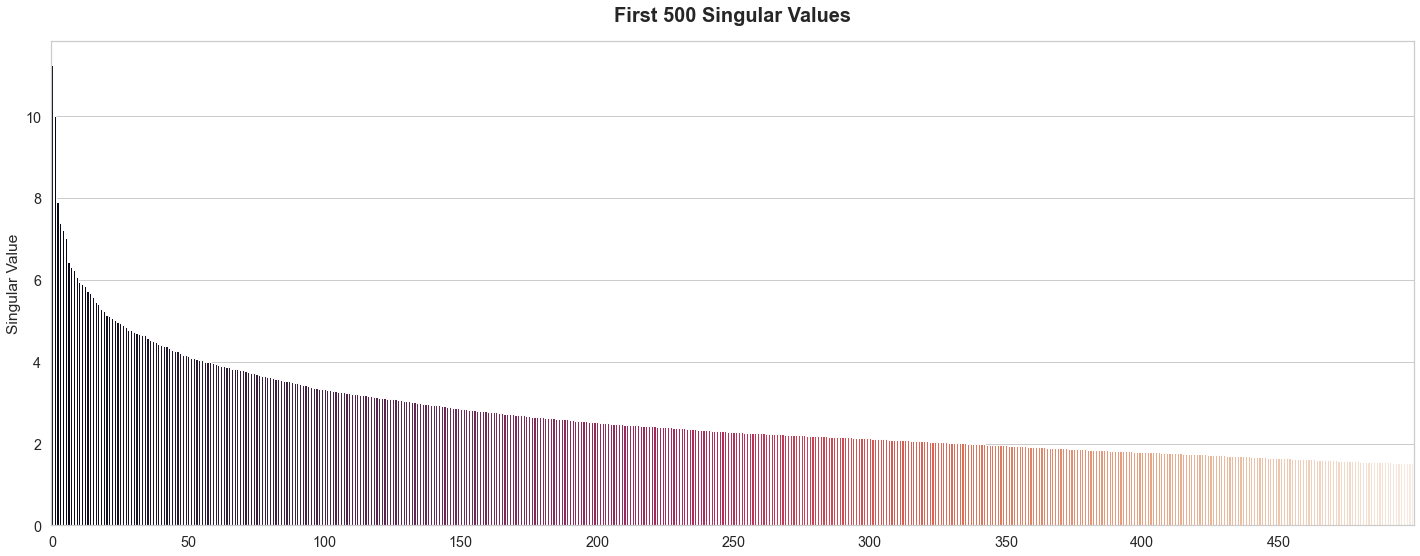

In [21]:
# Plot first n singular values

first_n = 500
plt.figure(figsize=(20,8))
sns.barplot(x=list(range(first_n)), y = S[:first_n], palette="rocket")
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.3)
plt.xticks(list(range(0,first_n,50)))
plt.title(f'First {first_n} Singular Values', size=20, weight='bold', pad=20)
plt.ylabel('Singular Value')
plt.tight_layout()
plt.show()

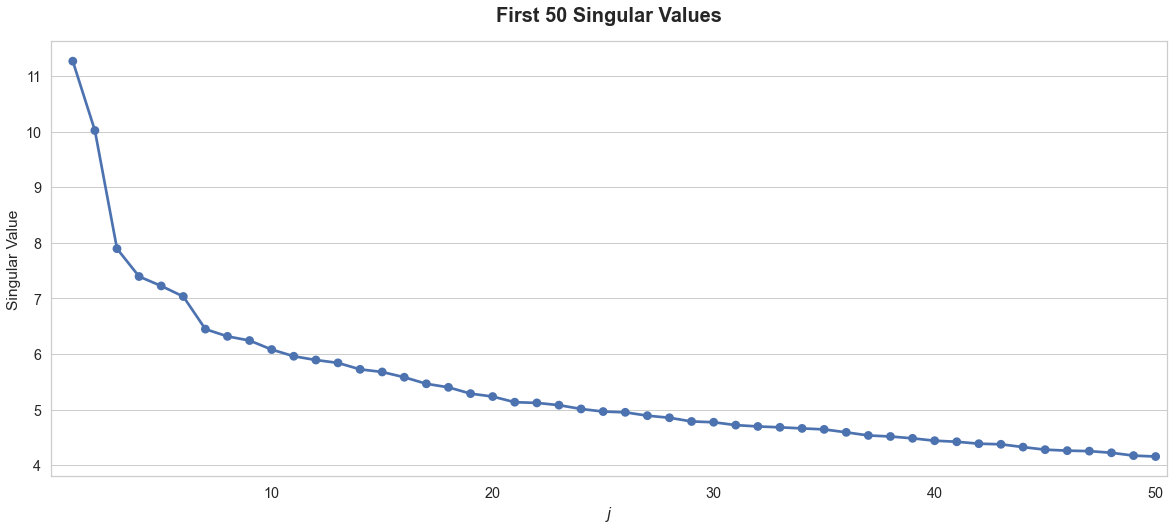

In [22]:

first_n = 50
fig2 = plt.figure(figsize=(20,8))
Svalue = pd.DataFrame(S, columns=['Singular Value']).reset_index().head(50)
fig2 = sns.pointplot(x=Svalue['index']+1, y=Svalue['Singular Value'], data=Svalue, markers='o')
fig2.set_xlabel('$j$')
fig2.set_xticks(range(-1,50,10))
plt.title(f'First {first_n} Singular Values', size=20, weight='bold', pad=20)
plt.show()

In [23]:
# Heuristic method (cumulative % variance explained S)
goal_var = .90
pct_variance_exp =(S**2).cumsum()/(S**2).sum()
heuristic_k = np.argwhere(pct_variance_exp>goal_var).min()
print(f'90% variance explained: {heuristic_k} concepts')

90% variance explained: 614 concepts


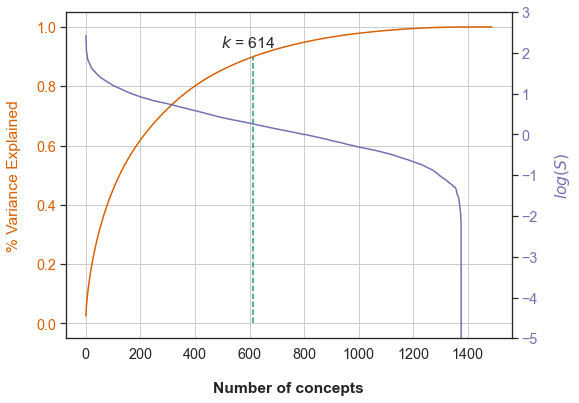

In [24]:
# % Variance explained
fig, ax3 = plt.subplots(figsize=(8,6))

sns.set_theme(context='notebook', style='ticks' ,palette='rocket', font_scale=1.3)
color = sns.color_palette("Dark2")[1]
ax3.set_xlabel('Number of concepts', labelpad=20, weight='bold')
ax3.set_ylabel('% Variance Explained', color=color, labelpad=15)
ax3.plot((S**2).cumsum()/(S**2).sum(), color=color)
ax3.tick_params(axis='y', labelcolor=color)
plt.vlines(heuristic_k, 0, .9, linestyles='--', colors=sns.color_palette("Dark2")[0])
plt.text(heuristic_k-120, .93, f'$k$ = {heuristic_k} ')

ax4 = ax3.twinx()  # instantiate a second axes
color = sns.color_palette("Dark2")[2]
ax4.set_ylabel('$log(S)$', color=color, labelpad=15)
ax4.plot(np.log(S), color=color)
ax4.tick_params(axis='y', labelcolor=color)
ax4.set_ybound(-5, 3)
plt.show()

### Select $k$ with Gavish & Donoho (2014) approach


In [25]:
%run -i optht.py

# beta = n/m
beta = min(tfidf_mat.shape)/max(tfidf_mat.shape)

k, cutoff = optht(beta, S, sigma=None)

# "sigma" here refers to the level of noise, 'None' indicates the noise level is unknown


print(f'Optimal k = {k}')


Optimal k = 320


In [26]:
# Truncate matrices at optimal k
U_optim, S_optim, VT_optim = U[:,range(k)], S[range(k)], VT[range(k),:]
X_new = (U_optim * S_optim).dot(VT_optim)

Ut = U_optim * S_optim

In [27]:
# compute the noise matrix and its singular values
noise = tfidf_mat-X_new
U_noise, S_noise, VT_noise = np.linalg.svd(noise, full_matrices=0)

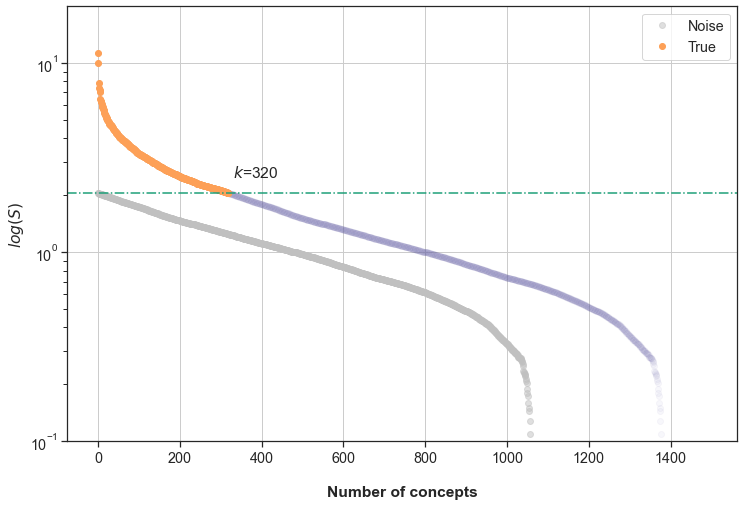

In [28]:
## Gavish & Donoho method
fig5,ax5 = plt.subplots(figsize=(12,8))


sns.set_theme(context='notebook', style='ticks' ,palette='rocket', font_scale=1.3)
ax5.semilogy(S_noise,'o', color='silver',alpha = .5, label='Noise', linewidth=.1) # noise singular values
ax5.semilogy(S, 'o', c=sns.color_palette("Dark2")[2],alpha =.05)
ax5.semilogy(S_optim,'o', c=sns.color_palette("Oranges")[2], label='True')
ax5.set_ybound(pow(10,-1), pow(10,1.3))

plt.axhline(y=cutoff, color=sns.color_palette("Dark2")[0], linestyle='-.')
plt.xlabel('Number of concepts', labelpad=20, weight='bold')
plt.ylabel('$log(S)$')
ax5.grid()
ax5.legend()

plt.text(k+10, 2.5, f'$k$={k}')
plt.show()

In [29]:
# sklearn truncated SVD
lsa_model = TruncatedSVD(n_components=k, random_state=77)
lsa_Ut = lsa_model.fit_transform(tfidf_mat)
lsa_S = lsa_model.singular_values_
lsa_VT = lsa_model.components_

In [30]:
# Concept-term matrix
concept_term_mat=pd.DataFrame(VT_optim, columns=bow_transformer.get_feature_names_out(), index=['concept_' + str(i+1) for i in range(k)])
concept_term_mat.head()

abl    absent  absentmindedli  accessori     accid    acoust  \
concept_1 -0.000045 -0.000090       -0.000287  -0.000240 -0.000226 -0.006095   
concept_2 -0.000139 -0.000143       -0.000628  -0.000525 -0.000593  0.004430   
concept_3  0.000090  0.000372        0.001311   0.001151  0.004094 -0.000061   
concept_4 -0.000183 -0.000659       -0.001835  -0.001421  0.000785  0.000492   
concept_5 -0.000021 -0.000091        0.000298   0.000263  0.000056  0.000079   

            acrobat    across        ad     adult  ...     woven      wrap  \
concept_1 -0.000143 -0.011899 -0.000489 -0.002475  ... -0.000493 -0.000124   
concept_2 -0.000377 -0.031369 -0.000892 -0.002772  ... -0.000982 -0.000129   
concept_3  0.000501 -0.008449  0.002305  0.007764  ...  0.002640  0.001937   
concept_4 -0.000189  0.001449 -0.001469 -0.006634  ... -0.004237 -0.000428   
concept_5  0.000027 -0.002300  0.004729 -0.000157  ...  0.000058  0.006767   

             wrestl     write      yard      yell    yellow     young  \
concept_1 -0.006448 -0.002724 -0.007018 -0.000160 -0.022005 -0.037730   
concept_2 -0.016141 -0.005568 -0.014002 -0.000372 -0.045981 -0.032680   
concept_3 -0.007207  0.009348 -0.004541  0.000961  0.040873  0.104478   
concept_4  0.002829 -0.004018  0.001204  0.000580 -0.013087 -0.059453   
concept_5 -0.000557  0.004138 -0.000713 -0.000263 -0.001495 -0.007564   

                zoo  zucchini  
concept_1 -0.001402 -0.000447  
concept_2 -0.003475 -0.000478  
concept_3 -0.001616  0.004317  
concept_4  0.001199 -0.000577  
concept_5  0.000013  0.007127  

[5 rows x 1489 columns]

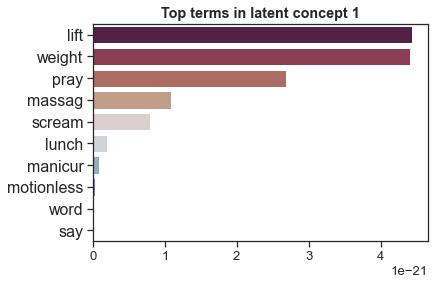

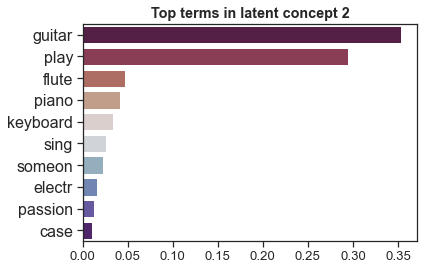

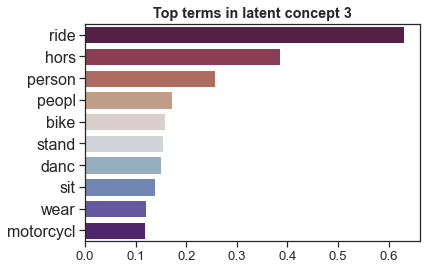

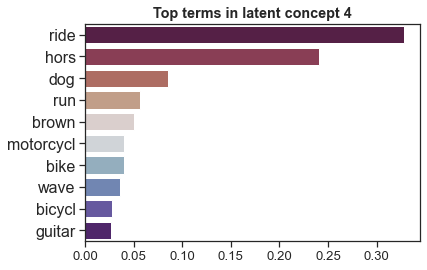

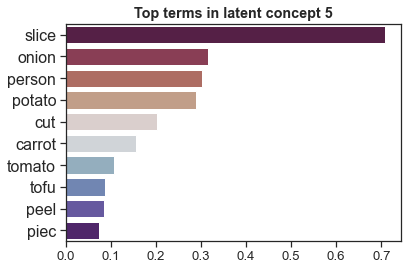

In [31]:
%matplotlib inline
sns.set_theme(context='notebook', style='ticks', font_scale=1.2)

n = 5
for i in range(n):
    top10=concept_term_mat.iloc[i,].sort_values(ascending=False)[:10]
    plt.title(f'Top terms in latent concept {str(i+1)}', weight='bold')
    sns.barplot(x=top10.values, y=top10.index, palette="twilight_shifted_r")
    plt.yticks(size=16, family='arial')
    plt.show()

### Pairwise Similarity Computation

Now that we have the transformed document-term matrix:  

$\begin{align} \hat{U}_{transformed} = U_{truncated} \times \Sigma_{truncated} \end{align} $

We can compute the cosine similarity between each vectorized documents

In [32]:
cosine_mat = cosine_similarity(Ut)
print(f'shape of cosine matrix: {cosine_mat.shape}')
pd.DataFrame(cosine_mat, index = ['doc'+str(i) for i in range(len(docs))], columns = ['doc'+str(i) for i in range(len(docs))])

shape of cosine matrix: (5000, 5000)


doc0      doc1      doc2      doc3      doc4      doc5      doc6  \
doc0     1.000000 -0.005109  0.160571 -0.010074 -0.008081  0.009986  0.402647   
doc1    -0.005109  1.000000  0.101429  0.163048 -0.000311  0.001476  0.000847   
doc2     0.160571  0.101429  1.000000  0.120041  0.013818 -0.000576 -0.000888   
doc3    -0.010074  0.163048  0.120041  1.000000  0.037774 -0.000239  0.002407   
doc4    -0.008081 -0.000311  0.013818  0.037774  1.000000  0.003055  0.001630   
...           ...       ...       ...       ...       ...       ...       ...   
doc4995 -0.011403 -0.001091  0.004260  0.001380  0.008015  0.003554 -0.002939   
doc4996  0.006821  0.000376 -0.005370  0.000310  0.004233  0.004809 -0.000089   
doc4997 -0.002785  0.074260 -0.006775  0.093497  0.000621  0.001586  0.001048   
doc4998 -0.022804  0.003432 -0.000155 -0.011470  0.005441  0.001729  0.002516   
doc4999 -0.013712  0.080794  0.123433  0.098067  0.008501 -0.002644  0.000893   

             doc7      doc8      doc9  ...   doc4990   doc4991   doc4992  \
doc0     0.011621 -0.018258 -0.055005  ...  0.006228 -0.008475  0.008785   
doc1    -0.000056  0.003822  0.012063  ...  0.000028  0.001281  0.269789   
doc2     0.002604  0.006065  0.030836  ...  0.005976  0.004252  0.145042   
doc3     0.001513  0.013412 -0.006262  ...  0.002247  0.000717  0.332489   
doc4     0.003453  0.002183  0.004257  ... -0.003261  0.002976 -0.000329   
...           ...       ...       ...  ...       ...       ...       ...   
doc4995  0.014245  0.261984 -0.006600  ... -0.005471 -0.000183 -0.007290   
doc4996  0.001411  0.002260  0.005055  ...  0.000836  0.005402  0.001355   
doc4997  0.000148  0.055936  0.012373  ...  0.195164  0.114967  0.201542   
doc4998  0.003890 -0.006277 -0.003791  ... -0.004118  0.004263  0.001103   
doc4999 -0.001073  0.186318 -0.023222  ...  0.163888 -0.001317  0.258017   

          doc4993   doc4994   doc4995   doc4996   doc4997   doc4998   doc4999  
doc0    -0.029586  0.402647 -0.011403  0.006821 -0.002785 -0.022804 -0.013712  
doc1     0.074731  0.000847 -0.001091  0.000376  0.074260  0.003432  0.080794  
doc2     0.105332 -0.000888  0.004260 -0.005370 -0.006775 -0.000155  0.123433  
doc3     0.092486  0.002407  0.001380  0.000310  0.093497 -0.011470  0.098067  
doc4     0.001370  0.001630  0.008015  0.004233  0.000621  0.005441  0.008501  
...           ...       ...       ...       ...       ...       ...       ...  
doc4995  0.006434 -0.002939  1.000000  0.003299  0.007485 -0.002138  0.009120  
doc4996 -0.001876 -0.000089  0.003299  1.000000 -0.001573 -0.000016 -0.000195  
doc4997  0.004381  0.001048  0.007485 -0.001573  1.000000  0.008477  0.005798  
doc4998 -0.006900  0.002516 -0.002138 -0.000016  0.008477  1.000000 -0.001568  
doc4999  0.094683  0.000893  0.009120 -0.000195  0.005798 -0.001568  1.000000  

[5000 rows x 5000 columns]

In [33]:
pair_ID=[]
cosine=[]

for i in range(df.shape[0]):
    pair_ID.append(i+1)
    cosine.append(cosine_mat[i,i+df.shape[0]])

pairwise_cosine = pd.DataFrame(data={'pair_ID': pair_ID, 'cosine': cosine})

In [34]:
item_pairs = pd.merge(df, pairwise_cosine, on='pair_ID', validate='one_to_one')
item_pairs

pair_ID                                         sentence_A  \
0           1  There is no horse tossing the cowboy in red an...   
1           2  A boy is wearing all black and is sliding down...   
2           3       A teenage girl is wearing beads that are red   
3           4  One man is wearing a black helmet and pushing ...   
4           5           There are no racers running down a track   
...       ...                                                ...   
2495     2496      There is no tennis player lunging to the left   
2496     2497                         Some women are not talking   
2497     2498  A dog, which is brown, and a black one are run...   
2498     2499               Two men are taking a break from work   
2499     2500  A man is wearing a clear plastic cap and a fac...   

                                             sentence_B  relatedness_score  \
0     A man is falling off a horse on a track and is...                2.6   
1                  A kid is speeding down a steep slide                4.1   
2     There is no young lady with light brown hair w...                3.2   
3           A biker wearing black is breaking the gears                2.3   
4                                Men are running a race                3.8   
...                                                 ...                ...   
2495  A tennis player with a green headband is hitti...                3.4   
2496                                The men are talking                2.5   
2497  A dark black dog and a light brown dog are pla...                3.9   
2498  Two construction workers are sitting up on the...                3.2   
2499  A woman by a brick wall is wearing a mask arou...                2.5   

        cosine  
0     0.223346  
1     0.609636  
2     0.229697  
3     0.207073  
4     0.303246  
...        ...  
2495  0.718385  
2496  0.566975  
2497  0.372287  
2498  0.025015  
2499  0.310070  

[2500 rows x 5 columns]

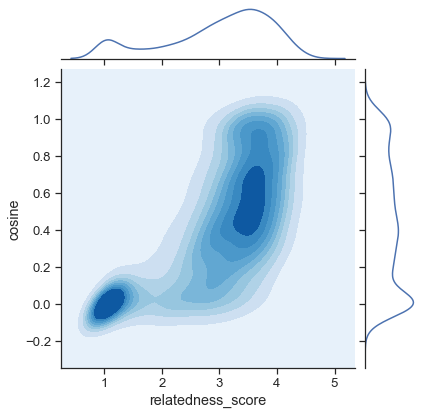

In [35]:
sns.jointplot(data=item_pairs, x='relatedness_score', y='cosine',
              kind='kde', cmap='Blues',
              shade=True, thresh=0)

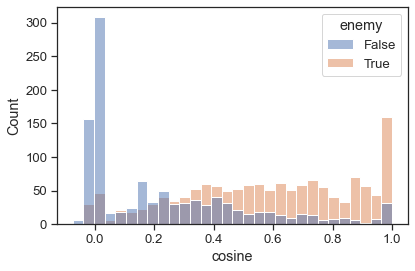

In [36]:
# create an enemy label
# here we arbitrarily label relatedness_score > 3 as enemy item pairs
item_pairs = item_pairs.assign(enemy=item_pairs.relatedness_score>3*1)
sns.histplot(data=item_pairs, x='cosine', hue='enemy', bins=30)
sns.set_theme(context='notebook', style='ticks', palette='Set2', font_scale=1.2)
plt.tight_layout()
plt.show()

In [37]:
# split data into 60% training and 40% test sets 

X_train, X_test, y_train, y_test = train_test_split(item_pairs[['cosine']], item_pairs['enemy'], test_size=0.5, random_state=77)


In [38]:
# apply support vector machine classifier

svm_classifier = svm.SVC().fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)
confusion_mat=confusion_matrix(y_test, y_pred)

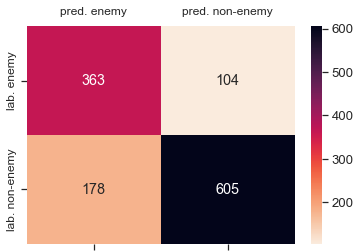

In [39]:
# plot confusion_mat
fig=plt.figure(figsize=(6,4))
fig=sns.heatmap(confusion_mat.transpose(), cmap='rocket_r', annot=True, fmt='g')
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.5)
fig.set_xticklabels(['pred. enemy', 'pred. non-enemy'], size=12)
fig.set_yticklabels(['lab. enemy', 'lab. non-enemy'], size=12)
fig.tick_params(axis="x", labelbottom=False, labeltop=True)
plt.show()

### Classification Metrics


$\text{Recall} = \frac{TP}{TP + FN}$

$\text{Precision} = \frac{TP}{TP + FP}$

$\text{F1 Score} = 2 \times \frac{\text{Recall} \times \text{Precision}}{\text{Recall} + \text{Precision}}$

In [40]:

tn, fp, fn, tp = confusion_mat.ravel()

print(f'Recall: {int(tp/(tp+fn)*100)}%')
print(f'Precision: {int(tp/(tp+fp)*100)}%')


Recall: 85%
Precision: 77%


In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.78      0.67      0.72       541
        True       0.77      0.85      0.81       709

    accuracy                           0.77      1250
   macro avg       0.77      0.76      0.77      1250
weighted avg       0.77      0.77      0.77      1250



### More Resources
- [nltk documentation](https://www.nltk.org) 
- [nltk book](https://www.nltk.org/book) 
- [Scikit-Learn user guide](https://scikit-learn.org/0.21/_downloads/scikit-learn-docs.pdf)

